In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            # layer = GENConv(channel_ls[i], channel_ls[i+1], aggr='powermean', learn_p=True, edge_dim=1)
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [6]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.2, gamma=0.2, dropout=0.5):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        # self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        # self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        # self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        dim_changer = self.dim_changer1 @ self.dim_changer2 
        A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        # dim_changer = self.dim_changer
        # A_dim_changer = self.A_dim_changer
        # Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        # new_A = F.tanh(F.relu(new_A))
        new_A = F.sigmoid(new_A)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [8]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [9]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [10]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls, alpha, epoch_weight):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)


    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * epoch_weight
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [11]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=8)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=8)
channels_ls = [32, 64, 128]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


3038396

In [14]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    beta = 1
    up_gamma = 1
    down_gamma = 1
    epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
            
        if (epoch + 1) % 10 == 0:
            epoch_weight = 1 / ((epoch + completed_epochs + 1) ** 0.2)


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            down_batch_loss = []
            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_batch_loss.append(down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1]))
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss = torch.mean(torch.stack(down_batch_loss))
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            del down_batch_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            up_batch_loss = []

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_batch_loss.append(up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.75, epoch_weight=epoch_weight))
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss = torch.mean(torch.stack(up_batch_loss))
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            del up_batch_loss
            torch.cuda.empty_cache()

        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'epoch {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [15]:
up_changer, down_changer, loss_log = train(300, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

100%|██████████| 21/21 [00:41<00:00,  1.95s/it]


epoch 0: down loss = 0.6296953076408023, up loss = 0.5100735908462888, down adj mae = 0.5739789959930238, up adj mae = 0.6064883584067935


 24%|██▍       | 5/21 [00:09<00:30,  1.88s/it]

In [17]:
min(loss_log['up_end_mae'])

0.13146179914474487

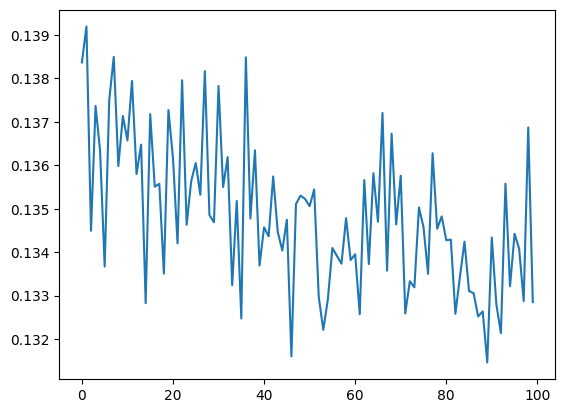

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'][-100:])), loss_log['up_end_mae'][-100:])
plt.show()

In [13]:
torch.save(up_changer.state_dict(), 'submission_files/tim_deep3/up_changer.pth')

In [29]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


In [30]:
torch.save(test_predictions, 'submission_files/tim_deep3/tim_deep3_pred.pt')

In [5]:
test_predictions = torch.load('submission_files/tim_deep3/tim_deep3_pred.pt')

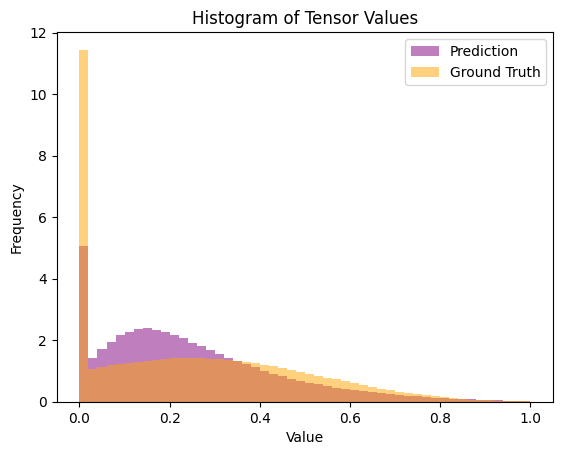

In [6]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

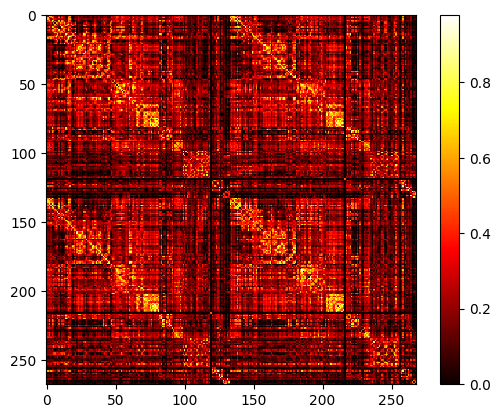

In [33]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [34]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep3/tim_deep3.csv')

# Cross Validation

In [15]:
from evaluation_fn import evaluate_predictions
from data_preparation import generate_histogram, generate_heatmap

def validation(up_changer, testloader, val_adj_hr, histogram=False, heatmap=False):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    if histogram:
        print(f'Histogram for Current Fold')
        generate_histogram(val_predictions.cpu(), val_adj_hr.cpu())
    if heatmap:
        print(f'First Difference Heatmap for Current Fold')
        generate_heatmap((val_adj_hr[0].cpu() - val_predictions[0].cpu()))

    return evaluate_predictions(val_predictions, val_adj_hr)

In [16]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, channels_ls = [32, 64, 128], histogram=False, heatmap=False):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr, histogram, heatmap)
        runs_results.append(val_metrics)


    return runs_results

100%|██████████| 14/14 [00:35<00:00,  2.53s/it]


epoch 0: down loss = 0.06410400835531098, up loss = 0.10989641078880855, down adj mae = 0.31765475230557577, up adj mae = 0.2952703705855778


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 1: down loss = 0.06174917386046478, up loss = 0.10500086258564677, down adj mae = 0.31044115126132965, up adj mae = 0.28492008575371336


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 2: down loss = 0.05895114690065384, up loss = 0.10249564956341471, down adj mae = 0.31302523612976074, up adj mae = 0.2885137413229261


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 3: down loss = 0.056864854746631215, up loss = 0.09915876228894506, down adj mae = 0.3033453438963209, up adj mae = 0.2831968814134598


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 4: down loss = 0.054824999400547574, up loss = 0.09498162514397077, down adj mae = 0.2930245356900351, up adj mae = 0.27419391168015345


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 5: down loss = 0.05289630378995623, up loss = 0.09182527022702354, down adj mae = 0.2938525250979832, up adj mae = 0.2669476121664047


100%|██████████| 14/14 [00:34<00:00,  2.48s/it]


epoch 6: down loss = 0.05143402862761702, up loss = 0.08898684542093958, down adj mae = 0.2939251129116331, up adj mae = 0.2665256570492472


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 7: down loss = 0.05023844114371708, up loss = 0.08573550997035843, down adj mae = 0.28902571967669893, up adj mae = 0.2572609473552023


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 8: down loss = 0.04808061623147556, up loss = 0.08423442499978202, down adj mae = 0.2743210047483444, up adj mae = 0.2501609038029398


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 9: down loss = 0.04691823625138828, up loss = 0.0775356830230781, down adj mae = 0.281088616166796, up adj mae = 0.25347273158175604


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 10: down loss = 0.04474253553364958, up loss = 0.0762439024235521, down adj mae = 0.27548582426139284, up adj mae = 0.24939325558287756


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 11: down loss = 0.0436749743031604, up loss = 0.07368662421192441, down adj mae = 0.27779542548315866, up adj mae = 0.24616248905658722


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 12: down loss = 0.04237243213823864, up loss = 0.07109367315258298, down adj mae = 0.2743439993688038, up adj mae = 0.24047529697418213


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 13: down loss = 0.041477685794234276, up loss = 0.06884762325457164, down adj mae = 0.27026367826121195, up adj mae = 0.23707582695143564


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 14: down loss = 0.04018244679485049, up loss = 0.06737742306930679, down adj mae = 0.27465583277600153, up adj mae = 0.24258677980729512


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 15: down loss = 0.039165613906724114, up loss = 0.06570370415491718, down adj mae = 0.2708040624856949, up adj mae = 0.22662325842039927


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 16: down loss = 0.0386796843792711, up loss = 0.06412707189364093, down adj mae = 0.2655728704163006, up adj mae = 0.23393939222608293


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 17: down loss = 0.03672301210463047, up loss = 0.06265931310398239, down adj mae = 0.25967915994780405, up adj mae = 0.23121689047132218


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 18: down loss = 0.035457361223442216, up loss = 0.060646869242191315, down adj mae = 0.2577935425298555, up adj mae = 0.2246751668197768


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 19: down loss = 0.034797429240175655, up loss = 0.05878479965031147, down adj mae = 0.2570787327630179, up adj mae = 0.22237011258091247


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 20: down loss = 0.03404455791626658, up loss = 0.057312311604619026, down adj mae = 0.258245695914541, up adj mae = 0.2204564011522702


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 21: down loss = 0.03270265992198672, up loss = 0.05571850735161986, down adj mae = 0.2496439931648118, up adj mae = 0.21514029055833817


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 22: down loss = 0.03156672524554389, up loss = 0.0546653542135443, down adj mae = 0.25104176678827833, up adj mae = 0.21750472805329732


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 23: down loss = 0.03051612592701401, up loss = 0.053060468818460195, down adj mae = 0.24499001566852843, up adj mae = 0.2128959745168686


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 24: down loss = 0.0297479990071484, up loss = 0.05233915336430073, down adj mae = 0.24204017860548838, up adj mae = 0.2058123339499746


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 25: down loss = 0.028748324939182827, up loss = 0.05119795059519155, down adj mae = 0.2456773817539215, up adj mae = 0.21158359199762344


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 26: down loss = 0.02799652037875993, up loss = 0.0497706974191325, down adj mae = 0.2387638943535941, up adj mae = 0.2034270582454545


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 27: down loss = 0.026881934143602848, up loss = 0.04880926385521889, down adj mae = 0.23893800377845764, up adj mae = 0.20631909476859228


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 28: down loss = 0.0263516865670681, up loss = 0.04805645320032324, down adj mae = 0.23693222658974783, up adj mae = 0.20323156246117183


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 29: down loss = 0.025545754469931126, up loss = 0.04713640095932143, down adj mae = 0.23451138926403864, up adj mae = 0.2008594615118844


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 30: down loss = 0.0245563020663602, up loss = 0.04540998701538358, down adj mae = 0.23451135201113565, up adj mae = 0.1983551691685404


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 31: down loss = 0.023835372046700547, up loss = 0.04532088179673467, down adj mae = 0.23444457671472005, up adj mae = 0.20063221880367824


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 32: down loss = 0.023498129099607468, up loss = 0.04463475250772068, down adj mae = 0.2322579888360841, up adj mae = 0.19861561698572977


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 33: down loss = 0.022960877179035118, up loss = 0.04352288294051375, down adj mae = 0.2251656534416335, up adj mae = 0.1970761897308486


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 34: down loss = 0.02257475576230458, up loss = 0.04301386619252818, down adj mae = 0.22400792581694468, up adj mae = 0.19398702361754008


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 35: down loss = 0.02139996750546353, up loss = 0.04176149171377931, down adj mae = 0.2260202659027917, up adj mae = 0.19213971602065222


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 36: down loss = 0.02088446170091629, up loss = 0.04179574362933636, down adj mae = 0.22269061420645034, up adj mae = 0.19035026963268006


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 37: down loss = 0.020280555955001285, up loss = 0.04044740540640695, down adj mae = 0.22083748131990433, up adj mae = 0.18901021778583527


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 38: down loss = 0.01966204441019467, up loss = 0.04009410020496164, down adj mae = 0.2163196269954954, up adj mae = 0.1889591802443777


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 39: down loss = 0.019252331794372628, up loss = 0.03962343159530844, down adj mae = 0.21686936169862747, up adj mae = 0.1883120345217841


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 40: down loss = 0.018662052495138987, up loss = 0.038069898528712134, down adj mae = 0.21344744307654245, up adj mae = 0.1837363573057311


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 41: down loss = 0.018257549963891506, up loss = 0.0382628861282553, down adj mae = 0.21760835179260798, up adj mae = 0.1882465652057103


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 42: down loss = 0.017911503091454506, up loss = 0.03803872024374349, down adj mae = 0.21226428662027633, up adj mae = 0.18613265561206


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 43: down loss = 0.017340143344232013, up loss = 0.03745106767330851, down adj mae = 0.2084791979619435, up adj mae = 0.18683392448084696


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 44: down loss = 0.01675914234614798, up loss = 0.03663186516080584, down adj mae = 0.20797378569841385, up adj mae = 0.18062947051865713


100%|██████████| 14/14 [00:34<00:00,  2.49s/it]


epoch 45: down loss = 0.016248388016330346, up loss = 0.03620056781385626, down adj mae = 0.20879231925521577, up adj mae = 0.1807126488004412


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 46: down loss = 0.015986435381429537, up loss = 0.035323325278503556, down adj mae = 0.20565853800092423, up adj mae = 0.1780566264476095


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 47: down loss = 0.01570099252941353, up loss = 0.03565567572202001, down adj mae = 0.20585480970995768, up adj mae = 0.18173231503793172


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 48: down loss = 0.01528265852747219, up loss = 0.035257805937102864, down adj mae = 0.20314532944134303, up adj mae = 0.1806533464363643


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 49: down loss = 0.014876716238047396, up loss = 0.03440344040947301, down adj mae = 0.19893795677593776, up adj mae = 0.17717274917023523


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 50: down loss = 0.014536575946424688, up loss = 0.034493228154523034, down adj mae = 0.1998444369861058, up adj mae = 0.17589811980724335


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 51: down loss = 0.014260297508112021, up loss = 0.034116312728396485, down adj mae = 0.19653637175049102, up adj mae = 0.17541014509541647


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 52: down loss = 0.013860958694879497, up loss = 0.03358138033321926, down adj mae = 0.2018311960356576, up adj mae = 0.17693099485976355


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 53: down loss = 0.013614987821451255, up loss = 0.033093303841139586, down adj mae = 0.2010540994150298, up adj mae = 0.17908046288149698


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 54: down loss = 0.013144679301019226, up loss = 0.03255030033843858, down adj mae = 0.19601953561816896, up adj mae = 0.17467902494328363


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 55: down loss = 0.012868076097220182, up loss = 0.03248594581548657, down adj mae = 0.19446691551378795, up adj mae = 0.174882496041911


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 56: down loss = 0.012671344580927066, up loss = 0.032195287623575757, down adj mae = 0.19119947403669357, up adj mae = 0.17249626134123122


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 57: down loss = 0.012339366666440452, up loss = 0.0316908923642976, down adj mae = 0.1939686888030597, up adj mae = 0.17481449459280288


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 58: down loss = 0.012183951546571084, up loss = 0.031444928608834743, down adj mae = 0.19026348207678115, up adj mae = 0.17090068757534027


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 59: down loss = 0.011792351159134082, up loss = 0.031089616806379387, down adj mae = 0.189583349440779, up adj mae = 0.17131292181355612


100%|██████████| 14/14 [00:34<00:00,  2.48s/it]


epoch 60: down loss = 0.01181913393416575, up loss = 0.03108310287020036, down adj mae = 0.18993365977491652, up adj mae = 0.16880265729767935


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 61: down loss = 0.011366319110883134, up loss = 0.030509085527488163, down adj mae = 0.18655003287962504, up adj mae = 0.16855244764259883


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 62: down loss = 0.01115701487287879, up loss = 0.03040830245507615, down adj mae = 0.18553108615534647, up adj mae = 0.1726984903216362


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 63: down loss = 0.010920986134026731, up loss = 0.030103492018367563, down adj mae = 0.18677400797605515, up adj mae = 0.16688570380210876


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 64: down loss = 0.010840392072818108, up loss = 0.02982656897178718, down adj mae = 0.17953172538961684, up adj mae = 0.1677652576139995


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 65: down loss = 0.010497428277241332, up loss = 0.0297445770619171, down adj mae = 0.18443766768489564, up adj mae = 0.16843976080417633


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 66: down loss = 0.010325162871075528, up loss = 0.029603897860007628, down adj mae = 0.18414501526526042, up adj mae = 0.16726130034242356


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 67: down loss = 0.010084512643516064, up loss = 0.02974284573325089, down adj mae = 0.18534920045307704, up adj mae = 0.17020187739815032


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 68: down loss = 0.00993458234838077, up loss = 0.030075064727238247, down adj mae = 0.18284007800476892, up adj mae = 0.16861409481082643


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 69: down loss = 0.0098590829542705, up loss = 0.029541381102587496, down adj mae = 0.17818626016378403, up adj mae = 0.16556978119271143


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 70: down loss = 0.009559043616588627, up loss = 0.028951616558645452, down adj mae = 0.179244621523789, up adj mae = 0.1658784438456808


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 71: down loss = 0.009483934180544955, up loss = 0.028670497903866426, down adj mae = 0.17873286242995942, up adj mae = 0.16618999625955308


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 72: down loss = 0.009193920530378819, up loss = 0.028160103064562594, down adj mae = 0.17667182109185628, up adj mae = 0.1624168817486082


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 73: down loss = 0.009098056770328964, up loss = 0.02805486254926239, down adj mae = 0.1759020569069045, up adj mae = 0.16470592149666377


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 74: down loss = 0.00893729506060481, up loss = 0.027853142204029218, down adj mae = 0.1781877257994243, up adj mae = 0.16737521971975053


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 75: down loss = 0.008848441831235374, up loss = 0.027653305791318417, down adj mae = 0.17492108047008514, up adj mae = 0.16226049619061605


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 76: down loss = 0.008764330364231552, up loss = 0.027672923036984036, down adj mae = 0.1754800836954798, up adj mae = 0.16272791687931334


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 77: down loss = 0.008520219075892652, up loss = 0.02752107208860772, down adj mae = 0.17334791805062974, up adj mae = 0.16104506807667868


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 78: down loss = 0.008341383721147264, up loss = 0.02731429399656398, down adj mae = 0.17274601012468338, up adj mae = 0.1600176841020584


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 79: down loss = 0.008279897472155946, up loss = 0.02710048428603581, down adj mae = 0.1756700383765357, up adj mae = 0.16286870198590414


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 80: down loss = 0.008244314097932406, up loss = 0.026920255007488385, down adj mae = 0.17394468933343887, up adj mae = 0.16307075640984944


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 81: down loss = 0.008132626601893986, up loss = 0.026738451394651617, down adj mae = 0.171712332538196, up adj mae = 0.1603281327656337


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 82: down loss = 0.007862901182046958, up loss = 0.026617743873170445, down adj mae = 0.17340294591018132, up adj mae = 0.16010738164186478


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 83: down loss = 0.007937307203454631, up loss = 0.02644046795155321, down adj mae = 0.17232750143323625, up adj mae = 0.15937982818910054


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 84: down loss = 0.007700201556352633, up loss = 0.026295526485357965, down adj mae = 0.16942925644772394, up adj mae = 0.15845646070582525


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 85: down loss = 0.007616314438304731, up loss = 0.026116373549614633, down adj mae = 0.1692346345101084, up adj mae = 0.16044537403753825


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 86: down loss = 0.007466271952060717, up loss = 0.026063895651272366, down adj mae = 0.167826061802251, up adj mae = 0.16112095969063894


100%|██████████| 14/14 [00:34<00:00,  2.48s/it]


epoch 87: down loss = 0.007441625631015215, up loss = 0.02583476116082498, down adj mae = 0.17028721102646419, up adj mae = 0.15998027473688126


100%|██████████| 14/14 [00:33<00:00,  2.39s/it]


epoch 88: down loss = 0.007363914678405438, up loss = 0.02577515478645052, down adj mae = 0.1699850633740425, up adj mae = 0.16099526520286286


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 89: down loss = 0.007297478716022202, up loss = 0.02562349023563521, down adj mae = 0.16873528808355331, up adj mae = 0.1583111733198166


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 90: down loss = 0.007126410258933902, up loss = 0.02554156125656196, down adj mae = 0.16489310562610626, up adj mae = 0.15772255616528646


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 91: down loss = 0.00702812645717391, up loss = 0.025450241485876695, down adj mae = 0.1669123981680189, up adj mae = 0.15653475054672786


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 92: down loss = 0.006938637566885778, up loss = 0.0252894503729684, down adj mae = 0.16510825604200363, up adj mae = 0.1580233829362052


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


epoch 93: down loss = 0.006880626913958362, up loss = 0.025211998660649573, down adj mae = 0.16640738930021012, up adj mae = 0.1575103380850383


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 94: down loss = 0.006854825486828174, up loss = 0.025130490639380047, down adj mae = 0.16642246288912638, up adj mae = 0.15797486688409532


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 95: down loss = 0.006709997641987034, up loss = 0.025092730963868753, down adj mae = 0.1646034504686083, up adj mae = 0.15629583384309495


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 96: down loss = 0.006722060265019536, up loss = 0.02513594433133091, down adj mae = 0.16618526301213674, up adj mae = 0.1597598705972944


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 97: down loss = 0.0065903883161289355, up loss = 0.02500195974217994, down adj mae = 0.16152821800538472, up adj mae = 0.15503406524658203


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 98: down loss = 0.006659637305087277, up loss = 0.02490934689662286, down adj mae = 0.16477956942149571, up adj mae = 0.1579402812889644


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 99: down loss = 0.006438759953847953, up loss = 0.02486687446279185, down adj mae = 0.16238436635051454, up adj mae = 0.15745116663830622


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 100: down loss = 0.00639933201351336, up loss = 0.024753018548446044, down adj mae = 0.1632781188402857, up adj mae = 0.15812073541539057


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 101: down loss = 0.006313215841406158, up loss = 0.024649941229394505, down adj mae = 0.16264777098383223, up adj mae = 0.15472238723720824


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 102: down loss = 0.006298346145610724, up loss = 0.02469262440821954, down adj mae = 0.1606102724160467, up adj mae = 0.15539381546633585


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 103: down loss = 0.006159646602879677, up loss = 0.024575986101159027, down adj mae = 0.16004732783351625, up adj mae = 0.1535377066050257


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 104: down loss = 0.006149050114410264, up loss = 0.024519277470452443, down adj mae = 0.160313609455313, up adj mae = 0.1543874368071556


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 105: down loss = 0.006098530188735042, up loss = 0.02451708433883531, down adj mae = 0.16187061156545365, up adj mae = 0.15547471280608857


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 106: down loss = 0.006006634195468256, up loss = 0.02445384966475623, down adj mae = 0.1605096310377121, up adj mae = 0.15638896184308188


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 107: down loss = 0.005991476321859019, up loss = 0.024367672258189747, down adj mae = 0.15836214274168015, up adj mae = 0.15231810403721674


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 108: down loss = 0.005978619746331658, up loss = 0.024270515755883286, down adj mae = 0.16093627895627702, up adj mae = 0.15528972021171025


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 109: down loss = 0.005852721365434783, up loss = 0.024276928843132088, down adj mae = 0.15982972936970846, up adj mae = 0.15739781622375762


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 110: down loss = 0.005855276648487363, up loss = 0.024237805711371557, down adj mae = 0.1588116724576269, up adj mae = 0.15219331958464213


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 111: down loss = 0.005786985458273973, up loss = 0.02418715413659811, down adj mae = 0.15618229338100978, up adj mae = 0.152286667908941


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 112: down loss = 0.005697669927030802, up loss = 0.02416069300046989, down adj mae = 0.15823532108749663, up adj mae = 0.15519049550805772


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 113: down loss = 0.005709716950410179, up loss = 0.02414304736469473, down adj mae = 0.15898063672440393, up adj mae = 0.15622338013989584


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 114: down loss = 0.00562131790710347, up loss = 0.024141966631369933, down adj mae = 0.15735740321023123, up adj mae = 0.15418888947793416


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 115: down loss = 0.0055979592725634575, up loss = 0.024076094052621295, down adj mae = 0.15340787172317505, up adj mae = 0.15014798832791193


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 116: down loss = 0.0054860223816441634, up loss = 0.023955937741058215, down adj mae = 0.15647645613976888, up adj mae = 0.15304342018706457


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 117: down loss = 0.005527713236265949, up loss = 0.024012951978615353, down adj mae = 0.15780447317021234, up adj mae = 0.15528126167399542


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 118: down loss = 0.00546888291968831, up loss = 0.023985195638878003, down adj mae = 0.16011009365320206, up adj mae = 0.15766695461102895


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 119: down loss = 0.005446849690218057, up loss = 0.023930209688842297, down adj mae = 0.15633335709571838, up adj mae = 0.15260679061923707


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 120: down loss = 0.005327119758086545, up loss = 0.023869676382413933, down adj mae = 0.15626781966005052, up adj mae = 0.15230270688022887


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 121: down loss = 0.005374649938728128, up loss = 0.02395502437970468, down adj mae = 0.15290571855647223, up adj mae = 0.15049886490617478


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 122: down loss = 0.005276839781020369, up loss = 0.023863069313977445, down adj mae = 0.15480431275708334, up adj mae = 0.15482239531619207


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 123: down loss = 0.005262338290257114, up loss = 0.02385331956403596, down adj mae = 0.15296818422419683, up adj mae = 0.15248064803225653


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 124: down loss = 0.005228217990536775, up loss = 0.023813068866729736, down adj mae = 0.15310569639716828, up adj mae = 0.15068445248263224


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 125: down loss = 0.005109159575243082, up loss = 0.023758538333433016, down adj mae = 0.1534650975040027, up adj mae = 0.15309479939086096


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 126: down loss = 0.005161456165036985, up loss = 0.02376071722911937, down adj mae = 0.1529489808848926, up adj mae = 0.15344508737325668


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 127: down loss = 0.0051140023528465205, up loss = 0.02372950821050576, down adj mae = 0.1507752857037953, up adj mae = 0.149524844118527


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 128: down loss = 0.005057109652885369, up loss = 0.023677818743245944, down adj mae = 0.15416156607014792, up adj mae = 0.1522932861532484


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 129: down loss = 0.005039886139067156, up loss = 0.023651940881141593, down adj mae = 0.15174350568226405, up adj mae = 0.15072394907474518


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 130: down loss = 0.004992056405171752, up loss = 0.023665281544838632, down adj mae = 0.1519519846354212, up adj mae = 0.15354943488325393


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 131: down loss = 0.004977607500872442, up loss = 0.023669231549969742, down adj mae = 0.15464099603039877, up adj mae = 0.15460863283702306


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 132: down loss = 0.004916026622855237, up loss = 0.02359728847763368, down adj mae = 0.1531984486750194, up adj mae = 0.15590771181242807


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 133: down loss = 0.004858883995828884, up loss = 0.02364219512258257, down adj mae = 0.1492762906210763, up adj mae = 0.15151138922997884


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 134: down loss = 0.004811198583671025, up loss = 0.023569314341459955, down adj mae = 0.1521709422980036, up adj mae = 0.15290379843541554


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


epoch 135: down loss = 0.004776714170085532, up loss = 0.023541848973504136, down adj mae = 0.14725565165281296, up adj mae = 0.14626081713608333


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 136: down loss = 0.004700482856216175, up loss = 0.02352871705910989, down adj mae = 0.1479439235159329, up adj mae = 0.14862584535564696


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 137: down loss = 0.00469563778356782, up loss = 0.023576226218470504, down adj mae = 0.14970797513212478, up adj mae = 0.15018771588802338


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 138: down loss = 0.00464145460032991, up loss = 0.023500156455806324, down adj mae = 0.14857368490525655, up adj mae = 0.1521587542125157


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 139: down loss = 0.004618721215852669, up loss = 0.023456500444029058, down adj mae = 0.14976906776428223, up adj mae = 0.1517877248781068


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 140: down loss = 0.004604757131476488, up loss = 0.023504730447062423, down adj mae = 0.15056280472448894, up adj mae = 0.15329645893403462


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 141: down loss = 0.0046143486563648495, up loss = 0.023561110853084495, down adj mae = 0.14929870941809245, up adj mae = 0.15033584833145142


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 142: down loss = 0.0045422281005552834, up loss = 0.02344978361257485, down adj mae = 0.14775648819548742, up adj mae = 0.14728544120277678


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 143: down loss = 0.004533231790576663, up loss = 0.023438867580677782, down adj mae = 0.14923794567584991, up adj mae = 0.1514307984283992


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 144: down loss = 0.004483286125053253, up loss = 0.023402980794864043, down adj mae = 0.14938707969018392, up adj mae = 0.1516369538647788


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 145: down loss = 0.004509557437683854, up loss = 0.023570704140833447, down adj mae = 0.14645165737186158, up adj mae = 0.1499173077089446


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 146: down loss = 0.004439741871984941, up loss = 0.02336276282689401, down adj mae = 0.1493150389620236, up adj mae = 0.15184037280934198


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 147: down loss = 0.004440688095720751, up loss = 0.023356790920453414, down adj mae = 0.1479562052658626, up adj mae = 0.15046923075403487


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 148: down loss = 0.0043614433878766635, up loss = 0.023430693362440382, down adj mae = 0.15058395266532898, up adj mae = 0.15213469841650554


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 149: down loss = 0.004389537930754679, up loss = 0.023398392035492828, down adj mae = 0.14806279433625086, up adj mae = 0.15113994904926845


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 150: down loss = 0.004332441603764892, up loss = 0.023308364009218558, down adj mae = 0.1471689992717334, up adj mae = 0.15023852565458842


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 151: down loss = 0.004335335422573345, up loss = 0.023304978784705912, down adj mae = 0.14468395922865188, up adj mae = 0.1490216042314257


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 152: down loss = 0.0043429718685469455, up loss = 0.023307092088673795, down adj mae = 0.14866911726338522, up adj mae = 0.1517691814473697


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 153: down loss = 0.004316652692588312, up loss = 0.023267660423048904, down adj mae = 0.14919699409178325, up adj mae = 0.1513004515852247


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 154: down loss = 0.004290183740002769, up loss = 0.02329126319714955, down adj mae = 0.14723483898809978, up adj mae = 0.15147699309246881


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 155: down loss = 0.0042583185880045804, up loss = 0.023269721705998694, down adj mae = 0.14810062838452204, up adj mae = 0.15143009700945445


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 156: down loss = 0.004246434828798685, up loss = 0.023266996523099288, down adj mae = 0.14734207200152533, up adj mae = 0.1521802544593811


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 157: down loss = 0.004199796007014811, up loss = 0.02324082502829177, down adj mae = 0.14691457684550965, up adj mae = 0.15084104452814376


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 158: down loss = 0.004200480578999434, up loss = 0.023292081696646556, down adj mae = 0.1493364189352308, up adj mae = 0.15404590325696127


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 159: down loss = 0.004196697912578072, up loss = 0.02325635762619121, down adj mae = 0.14482887834310532, up adj mae = 0.1498270407319069


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 160: down loss = 0.004132978501729667, up loss = 0.023245133193475858, down adj mae = 0.14870063215494156, up adj mae = 0.15120142698287964


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 161: down loss = 0.004134064124497984, up loss = 0.023183983750641346, down adj mae = 0.14183005477700913, up adj mae = 0.14641963903393065


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 162: down loss = 0.004126655885816685, up loss = 0.023246439706001962, down adj mae = 0.1477326676249504, up adj mae = 0.15317313266651972


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 163: down loss = 0.004092134851297098, up loss = 0.02319446618535689, down adj mae = 0.14318694812910898, up adj mae = 0.14586324031863893


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 164: down loss = 0.00409318194059389, up loss = 0.023211409603910788, down adj mae = 0.1471840664744377, up adj mae = 0.15098462040935243


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 165: down loss = 0.004072125452304525, up loss = 0.023147096059152057, down adj mae = 0.14779186355216162, up adj mae = 0.15377050106014525


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 166: down loss = 0.004058736709079572, up loss = 0.023075669737798826, down adj mae = 0.1455653299178396, up adj mae = 0.1503060758113861


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 167: down loss = 0.004044854547828436, up loss = 0.02311665684516941, down adj mae = 0.14570726880005427, up adj mae = 0.15029696907315934


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 168: down loss = 0.004020130527870995, up loss = 0.023162955019090856, down adj mae = 0.14745645650795527, up adj mae = 0.15053543980632508


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 169: down loss = 0.004006363850619111, up loss = 0.023047776892781258, down adj mae = 0.14589865399258478, up adj mae = 0.1500258349946567


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 170: down loss = 0.003985203553124198, up loss = 0.023059625045529435, down adj mae = 0.14661795326641627, up adj mae = 0.15178218377488


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 171: down loss = 0.004001107732100146, up loss = 0.023312992549368312, down adj mae = 0.14408755515302932, up adj mae = 0.15054407928671157


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 172: down loss = 0.003924961933600051, up loss = 0.02310686239174434, down adj mae = 0.14561635787997926, up adj mae = 0.14982753140585764


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 173: down loss = 0.003950621849591178, up loss = 0.023140612723571912, down adj mae = 0.14236783874886377, up adj mae = 0.14543286178793227


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 174: down loss = 0.003943740573179509, up loss = 0.023161931495581354, down adj mae = 0.14180306238787516, up adj mae = 0.1473602397101266


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 175: down loss = 0.003930292757494109, up loss = 0.02312073776764529, down adj mae = 0.14509139209985733, up adj mae = 0.15060172549315862


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 176: down loss = 0.0038928495320890632, up loss = 0.023099044071776525, down adj mae = 0.14298551210335322, up adj mae = 0.14599095284938812


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


epoch 177: down loss = 0.0038908283126407434, up loss = 0.0231546140941126, down adj mae = 0.14591489093644278, up adj mae = 0.15260061089481627


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 178: down loss = 0.0038621519758765188, up loss = 0.02300255705735513, down adj mae = 0.14204140433243342, up adj mae = 0.14700693424258912


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 179: down loss = 0.003851290243411703, up loss = 0.023077933117747307, down adj mae = 0.14430880120822362, up adj mae = 0.14830225918974196


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 180: down loss = 0.003884254306155656, up loss = 0.02297862818730729, down adj mae = 0.1439515416111265, up adj mae = 0.1505415141582489


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 181: down loss = 0.0038375792958374533, up loss = 0.02298030017742089, down adj mae = 0.1453162995832307, up adj mae = 0.1511729976960591


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 182: down loss = 0.003833977971225977, up loss = 0.02305701920496566, down adj mae = 0.14023924512522562, up adj mae = 0.14458721450396947


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 183: down loss = 0.003826791104594512, up loss = 0.023035906122199128, down adj mae = 0.14449995649712427, up adj mae = 0.15077720050300872


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 184: down loss = 0.00380018912255764, up loss = 0.023080024203019484, down adj mae = 0.1437971368432045, up adj mae = 0.14896487231765473


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 185: down loss = 0.003797345711583538, up loss = 0.023004668232585703, down adj mae = 0.14456708942140853, up adj mae = 0.15136714918272837


100%|██████████| 14/14 [00:34<00:00,  2.48s/it]


epoch 186: down loss = 0.0037967193638905883, up loss = 0.022911365809185163, down adj mae = 0.14049660946641648, up adj mae = 0.14837875004325593


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 187: down loss = 0.0037470030531819376, up loss = 0.02293802465179137, down adj mae = 0.1425910389849118, up adj mae = 0.1476086037499564


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 188: down loss = 0.0037572740111500025, up loss = 0.022964510268398693, down adj mae = 0.14481756623302186, up adj mae = 0.1511385664343834


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 189: down loss = 0.0037268001220322083, up loss = 0.02298442300941263, down adj mae = 0.14508022687264852, up adj mae = 0.15311731504542486


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 190: down loss = 0.0037450720722387943, up loss = 0.022893292297210013, down adj mae = 0.14259769767522812, up adj mae = 0.14841421161379134


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 191: down loss = 0.0037251317740551065, up loss = 0.02292654836284263, down adj mae = 0.14499036542006902, up adj mae = 0.15154269337654114


100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


epoch 192: down loss = 0.0037059581705502103, up loss = 0.022921680073652948, down adj mae = 0.14246342756918498, up adj mae = 0.14760926791599818


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 193: down loss = 0.0037359678452568395, up loss = 0.02299182170203754, down adj mae = 0.14459541014262609, up adj mae = 0.15006698029381887


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 194: down loss = 0.003700846357138029, up loss = 0.022871661665184156, down adj mae = 0.14435143981661117, up adj mae = 0.15094146026032312


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 195: down loss = 0.0036892182626096265, up loss = 0.02288656309247017, down adj mae = 0.14004432835749217, up adj mae = 0.1444504303591592


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 196: down loss = 0.0036558016103559305, up loss = 0.022828908637166023, down adj mae = 0.1415797961609704, up adj mae = 0.14656254755599157


100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


epoch 197: down loss = 0.0036544924202774253, up loss = 0.022683167164879187, down adj mae = 0.1416708848306111, up adj mae = 0.14861263121877397


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 198: down loss = 0.0036496207217818926, up loss = 0.022938589166317667, down adj mae = 0.14352580266339438, up adj mae = 0.15192554252488272


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 199: down loss = 0.0036301016308633344, up loss = 0.02263441974563258, down adj mae = 0.14046073066336767, up adj mae = 0.14586646322693145
begin validation


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Histogram for Current Fold


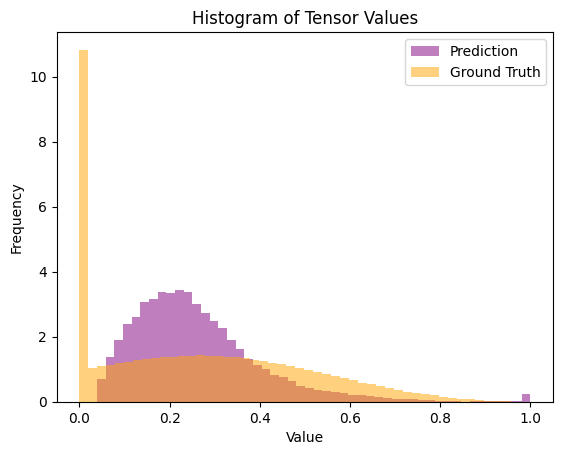

First Difference Heatmap for Current Fold


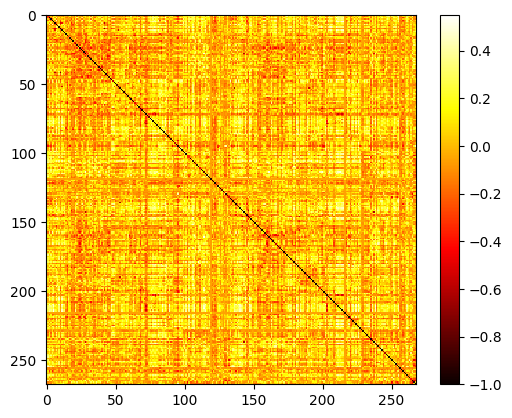

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [15:58<00:00, 17.11s/it]


MAE:  0.14416765
PCC:  0.6144463316230301
Jensen-Shannon Distance:  0.28544399688673944
Average MAE betweenness centrality: 0.017952626649395825
Average MAE eigenvector centrality: 0.013669573666169665
Average MAE PageRank centrality: 0.0005653815314402782


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 0: down loss = 0.0645793117582798, up loss = 0.10707301433597292, down adj mae = 0.32205046926225933, up adj mae = 0.28355077441249577


100%|██████████| 14/14 [00:33<00:00,  2.39s/it]


epoch 1: down loss = 0.06152885513646262, up loss = 0.10256658334817205, down adj mae = 0.3175054746014731, up adj mae = 0.2657655126282147


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 2: down loss = 0.05879107383745057, up loss = 0.09752369884933744, down adj mae = 0.3037737565381186, up adj mae = 0.27160691576344625


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 3: down loss = 0.05663281625935009, up loss = 0.09389146417379379, down adj mae = 0.31005782740456717, up adj mae = 0.2651950110282217


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 4: down loss = 0.05434779503515789, up loss = 0.09218302103025573, down adj mae = 0.3030141017266682, up adj mae = 0.26413439214229584


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 5: down loss = 0.05190620810857841, up loss = 0.09168540313839912, down adj mae = 0.2878095198954855, up adj mae = 0.255276158452034


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


epoch 6: down loss = 0.04987326503864357, up loss = 0.08623774243252617, down adj mae = 0.2966388038226536, up adj mae = 0.2509354555181095


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


epoch 7: down loss = 0.04878357930907181, up loss = 0.08528232414807592, down adj mae = 0.28508070217711584, up adj mae = 0.253436986889158


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


epoch 8: down loss = 0.046981201108012884, up loss = 0.08234445910368647, down adj mae = 0.2799243799277714, up adj mae = 0.24717777967453003


100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


epoch 9: down loss = 0.04501236176916531, up loss = 0.07588410483939308, down adj mae = 0.2804958862917764, up adj mae = 0.2511838802269527


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 10: down loss = 0.04452906708632197, up loss = 0.07351396924683026, down adj mae = 0.2726115978189877, up adj mae = 0.24221392933811461


100%|██████████| 14/14 [00:33<00:00,  2.38s/it]


epoch 11: down loss = 0.042546502713646205, up loss = 0.07177424590502467, down adj mae = 0.2714612824576242, up adj mae = 0.2410757009472166


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


epoch 12: down loss = 0.04213177412748337, up loss = 0.0704445732491357, down adj mae = 0.2639995440840721, up adj mae = 0.23106764256954193


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 13: down loss = 0.039622499740549495, up loss = 0.06923215543585164, down adj mae = 0.2638843549149377, up adj mae = 0.23438538930245809


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


epoch 14: down loss = 0.03872696762638433, up loss = 0.06623046845197678, down adj mae = 0.2651724975023951, up adj mae = 0.23006060825926916


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


epoch 15: down loss = 0.03749750714216914, up loss = 0.0642747695424727, down adj mae = 0.2600340981568609, up adj mae = 0.22506366137947356


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


epoch 16: down loss = 0.036434754729270935, up loss = 0.062943038929786, down adj mae = 0.26513495296239853, up adj mae = 0.22898792581898825


 57%|█████▋    | 8/14 [00:20<00:15,  2.52s/it]


KeyboardInterrupt: 

In [17]:
import gc

#del up_changer
#del down_changer
#del test_predictions
gc.collect()

torch.cuda.empty_cache()

cross_validate(200, 8, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=8, histogram=True, heatmap=True)